<h1 align='center'>Applications of LSTM – Generating Text</h1>

In [1]:
import os
from six.moves.urllib.request import urlretrieve
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Get Data

[Dowloading Stories](https://www.cs.cmu.edu/~spok/grimmtmp/). The dataset consists of 209 stories. These are the translations of some folk stories by the Grimm brothers.

In [2]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'
dir_name = 'data'

def download_data(url, filename, download_dir):
    """Download a file if not present, and make sure it's the right size."""
      
    # Create directories if doesn't exist
    os.makedirs(download_dir, exist_ok=True)
    
    # If file doesn't exist download
    if not os.path.exists(os.path.join(download_dir,filename)):
        filepath, _ = urlretrieve(url + filename, os.path.join(download_dir,filename))
    else:
        filepath = os.path.join(download_dir, filename)
        
    return filepath

# Number of files and their names to download
num_files = 209
filenames = [format(i, '03d')+'.txt' for i in range(1, num_files+1)]

# Download each file
for fn in filenames:
    download_data(url, fn, dir_name)
    
# Check if all files are downloaded
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name,filenames[i]))
    assert file_exists

print(f"{len(filenames)} files found.") 

209 files found.


## Train-Validation-Test Split

In [4]:
from sklearn.model_selection import train_test_split

random_state = 54321

filenames = [os.path.join(dir_name, file) for file in os.listdir(dir_name) if file!='.ipynb_checkpoints']

# First separate train and valid+test data
train_filenames, test_and_valid_filenames = train_test_split(filenames, test_size=0.2, 
                                                             random_state=random_state)

# Separate valid+test data to validation and test data
valid_filenames, test_filenames = train_test_split(test_and_valid_filenames, test_size=0.5,
                                                   random_state=random_state)

# Print out the sizes and some sample filenames
for subset_id, subset in zip(('train', 'valid', 'test'), (train_filenames, valid_filenames, test_filenames)):
    print(f"Got {len(subset)} files in the {subset_id} dataset (e.g. {subset[:3]})")

Got 167 files in the train dataset (e.g. ['data\\117.txt', 'data\\133.txt', 'data\\069.txt'])
Got 21 files in the valid dataset (e.g. ['data\\023.txt', 'data\\078.txt', 'data\\176.txt'])
Got 21 files in the test dataset (e.g. ['data\\129.txt', 'data\\207.txt', 'data\\170.txt'])


## Analyzing the vocabulary size

- We will process the text by breaking it into character-level bigrams (n-grams where n=2) and make a vocabulary out of the unique bigrams. 

- Using character-level bigrams helps us to language model with a reduced vocabulary, leading to faster model training.

For e.g.: "`The king was hunting in the forest`", would break down to a sequence of bigrams as follows: `[‘th’, ‘e ‘, ‘ki’, ‘ng’, ‘ w’, ‘as’, …]`

In [6]:
bigram_set = set()

# Go through each file in the training set
for file_name in train_filenames:
    document = [] # This will hold all the text
    with open(file_name, 'r') as f:
        for row in f:
            # Convert text to lower case to reduce input dimensionality
            document.append(row.lower())
        
        # Stiching all the text
        document = " ".join(document)
        
        # Updating the set with bigram
        bigram_set.update([document[i:i+2] for i in range(0, len(document), 2)])
        
        
n_vocab = len(bigram_set)
print(f"Found {n_vocab} unique bigrams")

Found 705 unique bigrams


## Defining the `tf.data` pipeline

We will now define a fully fledged data pipeline that is capable of reading the files from the disk and transforming the content into a format or structure that can be used to train the model.

<div align='center'>
    <b>Process for generating data to train the language model</b>
</div>

<div align='center'>
    <img src='images/data_pipe.png'/>
</div>

For example assume an ngram_width of 2, batch size of 1, and window_size of 5. This function would take the string `the king was hunting in the forest` and output:

```
Batch 1: ["th", "e ", "ki", " ng", " w"] -> ["e ", "ki", "ng", " w", "as"]
Batch 2: ["as", " h", "un", "ti", "ng"] -> [" h", "un", "ti", "ng", " i"]
...
```
The left list in each batch represents the input sequence, and the right list represents the target sequence. 

Note how the right list is simply the left one shifted one to the right. Also note how
there’s no overlap between the inputs in the two records. But in the actual function, we a small overlap between records is maintained.

In [7]:
def generate_tf_dataset(filenames, ngram_width, window_size, batch_size, shuffle=False):
    """ 
    Generate batched data from a list of files speficied
    
    Args:
        • filenames – A list of filenames containing the text to be used for the model
        • ngram_width – Width of the n-grams to be extracted
        • window_size – Length of the sequence of n-grams to be used to generate a single data
                        point for the model
        • batch_size – Size of the batch
        • shuffle – (defaults to False) Whether to shuffle the data or not
    """
    
    # Read the data 
    documents = []
    for file in filenames:
        doc = tf.io.read_file(file)
        doc = tf.strings.ngrams( # Create ngram from string
                    tf.strings.bytes_split( # Split text into characters
                         tf.strings.regex_replace( # Replace new lines with space
                              tf.strings.lower(
                                  doc
                              ), "\n", " "
                         )
                    ),
                    ngram_width, separator=''
                )
        documents.append(doc.numpy().tolist())
    
    # documents is a list of list of strings, where each string is a story
    # From that we generate a ragged tensor
    documents = tf.ragged.constant(documents)
    
    # Create a dataset where each row in the ragged tensor would be a sample
    doc_dataset = tf.data.Dataset.from_tensor_slices(documents)
    
    # We need to perform a quick transformation - tf.strings.ngrams would generate
    # all the ngrams (e.g. abcd -> ab, bc, cd) with overlap, however for our data
    # we do not need the overlap, so we need to skip the overlapping ngrams
    # the following line does that
    
    # Here, we simply get rid of the overlapping n-grams by taking only every 
    # nth n-gram in the sequence:
    doc_dataset = doc_dataset.map(lambda x: x[::ngram_width])
    
    # Here we are using a window function to generate windows from text
    # For a text sequence with window_size 3 and shift 1 you get
    # e.g. ab, cd, ef, gh, ij, ... -> [ab, cd, ef], [cd, ef, gh], [ef, gh, ij], ...
    # each of these windows is a single training sequence for our model
    doc_dataset = doc_dataset.flat_map(
                        lambda x: tf.data.Dataset.from_tensor_slices(
                                    x
                        ).window(
                            size=window_size+1, shift=int(window_size*0.75)
                        ).flat_map(
                            lambda window: window.batch(window_size+1, drop_remainder=True)
                        )
                  )
    
    # From each windowed sequence we generate input and target tuple
    # e.g. [ab, cd, ef] -> ([ab, cd], [cd, ef])
    doc_dataset = doc_dataset.map(lambda x: (x[:-1], x[1:]))
    
    # Shuffle the data if required
    doc_dataset = doc_dataset.shuffle(buffer_size=batch_size*10) if shuffle else doc_dataset
    
    # Batch the Data
    doc_dataset = doc_dataset.batch(batch_size=batch_size)
    
    return doc_dataset

- A RaggedTensor is a special type of tensor that can have dimensions that accept arbitrarily sized inputs. `tf.ragged.constant()`

```
Eg.:
    a = tf.ragged.constant([[1, 2, 3], [1,2], [1]])

    b = tf.RaggedTensor.from_row_splits([1,2,3,4,5,6,7], row_splits=[0, 3, 3, 6, 7])

    Here, each value in the row_splits argument defines where the subsequent row in the resulting tensor ends. For example, the first row will contain elements from index 0 to 3 (i.e. 0, 1, 2). This will output:

    <tf.RaggedTensor [[1, 2, 3], [], [4, 5, 6], [7]]>

    Shape: b.shape: [4, None]
```
- For example, it is almost impossible that all the stories would have the same number of n-grams in each as they vary from each other a lot. In this case, we will have arbitrarily long sequences of n-grams representing our stories. 

- Therefore, we can use a RaggedTensor to store these arbitrarily sized sequences.

* **

Explanation of above code
```
doc_dataset = doc_dataset.flat_map(
                        lambda x: tf.data.Dataset.from_tensor_slices(
                                    x
                        ).window(
                            size=window_size+1, shift=int(window_size*0.75)
                        ).flat_map(
                            lambda window: window.batch(window_size+1, drop_remainder=True)
                        )
                  )
```
After removing the overlapping ngrams. The dataset is transformed using `.flat_map` and `.window` to generate sliding windows of size `window_size+1` from the n-gram sequences. The windows are created with a shift that's 75% of `window_size`, leading to 25% overlapping between two consecutive sequences. Each window is then batched using `.batch` with `drop_remainder=True` to ensure consistent batch sizes.

* **

In [8]:
ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, 
                               batch_size, window_size, shuffle=True)

valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)
test_ds = generate_tf_dataset(test_filenames, ngram_length, window_size, batch_size)

### Generate few samples from the dataset function

In [10]:
ds = generate_tf_dataset(train_filenames, ngram_width=2, window_size=10, batch_size=1)

for record in ds.take(5):
    print(record[0].numpy(), '->', record[1].numpy())

[[b'th' b'er' b'e ' b'wa' b's ' b'on' b'ce' b' u' b'po' b'n ']] -> [[b'er' b'e ' b'wa' b's ' b'on' b'ce' b' u' b'po' b'n ' b'a ']]
[[b' u' b'po' b'n ' b'a ' b'ti' b'me' b' a' b' s' b'he' b'ph']] -> [[b'po' b'n ' b'a ' b'ti' b'me' b' a' b' s' b'he' b'ph' b'er']]
[[b' s' b'he' b'ph' b'er' b'd ' b'bo' b'y ' b'wh' b'os' b'e ']] -> [[b'he' b'ph' b'er' b'd ' b'bo' b'y ' b'wh' b'os' b'e ' b'fa']]
[[b'wh' b'os' b'e ' b'fa' b'me' b' s' b'pr' b'ea' b'd ' b'fa']] -> [[b'os' b'e ' b'fa' b'me' b' s' b'pr' b'ea' b'd ' b'fa' b'r ']]
[[b'ea' b'd ' b'fa' b'r ' b'an' b'd ' b'wi' b'de' b' b' b'ec']] -> [[b'd ' b'fa' b'r ' b'an' b'd ' b'wi' b'de' b' b' b'ec' b'au']]


## Implementing the Language Model

In [11]:
import tensorflow.keras.backend as K

K.clear_session()

### Defining the `TextVectorization` layer

define a TextVectorization layer to convert the sequences of n-grams to sequences of integer IDs:

In [12]:
from tensorflow.keras import layers
from tensorflow.keras import models


# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = layers.TextVectorization(max_tokens=n_vocab, standardize=None,
                                           split=None, input_shape=(window_size,))

# The the layer on data
text_vectorizer.adapt(train_ds)

In [13]:
text_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'e ', 'he', ' t', 'th', 'd ', ' a', ', ', ' h']

**Convert the targets from string ngrams to ngram IDs:**

Remember that our data pipelines output sequences of n-gram strings as inputs and targets. We need to convert the target sequences to sequences of n-gram IDs so that a loss can be computed

In [14]:
train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))
test_ds = test_ds.map(lambda x, y: (x, text_vectorizer(y)))

### Defining the LSTM model

Our model will have:
- The previously trained TextVectorization layer
- An embedding layer randomly initialized and jointly trained with the model
- Two LSTM layers each with 512 and 256 nodes respectively
- A fully-connected hidden layer with 1024 nodes and `ReLU` activation
- The final prediction layer with `n_vocab` nodes and `softmax` activation

In [15]:
K.clear_session()

lm_model = models.Sequential([text_vectorizer,
                              layers.Embedding(input_dim=n_vocab+2, output_dim=96),
                              layers.LSTM(512, return_state=False, return_sequences=True),
                              layers.LSTM(256, return_state=False, return_sequences=True),
                              layers.Dense(1024, activation='relu'),
                              layers.Dropout(0.5),
                              layers.Dense(n_vocab, activation='softmax')
                             ])

`K.clear_session()`, which is a function that clears the current TensorFlow session (e.g. layers and variables defined and their states). Otherwise, if you run multiple times in a notebook, it will create an unnecessary number of layers and variables.

Parameters of the LSTM layer in more detail:
- `return_state` – Setting this to `False` means that the layer outputs only the final output, whereas if set to `True`, it will return state vectors along with the final output of the layer. For example, for an LSTM layer, setting `return_state=True` means you’ll get three outputs: the final output, cell state, and hidden state. Note that the final output and the hidden state will be identical in this case.

- `return_sequences` – Setting this to true will cause the layer to output the full output sequences, as opposed to just the last output. For example, setting this to `False` will give you a `[b, n]`-sized output where `b` is the batch size and` n` is the number of nodes in the layer. If `True`, it will output a `[b, t, n]`-sized output, where `t` is the number of time steps.


In [16]:
lm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 96)           67872     
                                                                 
 lstm (LSTM)                 (None, 128, 512)          1247232   
                                                                 
 lstm_1 (LSTM)               (None, 128, 256)          787456    
                                                                 
 dense (Dense)               (None, 128, 1024)         263168    
                                                                 
 dropout (Dropout)           (None, 128, 1024)         0         
                                                        

### Defining metrics and compiling the model

- [Evaluation Metrics for Language Modeling - Chip Hyuen](https://thegradient.pub/understanding-evaluation-metrics-for-language-models/)

- [A Gentle Introduction to Information Entropy - mlmastery](https://machinelearningmastery.com/what-is-information-entropy/)

Accuracy is used as a general-purpose evaluation metric across different ML tasks. However, accuracy might not be cut out for this task, mainly because it relies on the model choosing the exact word/bigram for a given time step as in the dataset. However, languages are complex and there can be many different choices to generate the next word/bigram given a text. Therefore, NLP practitioners rely on a metric known as **perplexity**, 

- **Perplexity** *measures how "perplexed" or “surprised” the model was to see a `t+1` bigram given `1:t` bigrams.*

- **Perplexity is simply the entropy to the power of two.** 

- Entropy is a measure of the uncertainty or randomness of an event. The more uncertain the outcome of the event, the higher the entropy. Entropy Formula is:

$$H(X) = - \sum_{x \forall X}p(x) \log(p(x))$$

- In machine learning, to optimize ML models, *we measure the difference between the predicted probability distribution versus the target probability distribution for a given sample*. For that, we use **cross-entropy**, an extension of entropy for two distributions: 

$$\text{Categorical Crossentropy}(\hat{y}_i, y_i) = - \sum_{c=1}^{c}y_{i,c}\log(\hat{y}_{i,c})$$

Finally, we define perplexity as:

$$Perplexity = 2^{H(X)}$$

In [17]:
# Inspired by https://gist.github.com/Gregorgeous/dbad1ec22efc250c76354d949a13cec3
class PerplexityMetric(tf.keras.metrics.Mean):
    
    def __init__(self, name='perplexity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, 
                                                                           reduction='none')

    def _calculate_perplexity(self, real, pred):
        # The next 4 lines zero-out the padding from loss calculations, 
        # this follows the logic from: https://www.tensorflow.org/beta/tutorials/text/transformer#loss_and_metrics 			      
        loss_ = self.cross_entropy(real, pred)
      
        # Calculating the perplexity steps: 
        step1 = K.mean(loss_, axis=-1)
        perplexity = K.exp(step1)

        return perplexity 

    def update_state(self, y_true, y_pred, sample_weight=None):            
        perplexity = self._calculate_perplexity(y_true, y_pred)
        # Remember self.perplexity is a tensor (tf.Variable), 
        # so using simply "self.perplexity = perplexity" will result in error 
        # because of mixing EagerTensor and Graph operations 
        super().update_state(perplexity)

In [18]:
lm_model.compile(loss='sparse_categorical_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy', PerplexityMetric()])

lm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 96)           67872     
                                                                 
 lstm (LSTM)                 (None, 128, 512)          1247232   
                                                                 
 lstm_1 (LSTM)               (None, 128, 256)          787456    
                                                                 
 dense (Dense)               (None, 128, 1024)         263168    
                                                                 
 dropout (Dropout)           (None, 128, 1024)         0         
                                                        

### Training the model

In [19]:
lstm_history = lm_model.fit(train_ds, 
                            validation_data=valid_ds, 
                            epochs=50, workers=10)

Epoch 1/50
49/49 [==============================] - 16s 103ms/step - loss: 5.3574 - accuracy: 0.0313 - perplexity: 236.6229 - val_loss: 5.1160 - val_accuracy: 0.0392 - val_perplexity: 167.7276
Epoch 2/50
49/49 [==============================] - 5s 89ms/step - loss: 5.1417 - accuracy: 0.0343 - perplexity: 172.5728 - val_loss: 5.0897 - val_accuracy: 0.0391 - val_perplexity: 163.5045
Epoch 3/50
49/49 [==============================] - 5s 89ms/step - loss: 5.0430 - accuracy: 0.0411 - perplexity: 156.8100 - val_loss: 4.8478 - val_accuracy: 0.0641 - val_perplexity: 128.6614
Epoch 4/50
49/49 [==============================] - 5s 90ms/step - loss: 4.7109 - accuracy: 0.0855 - perplexity: 113.4167 - val_loss: 4.4596 - val_accuracy: 0.1093 - val_perplexity: 87.6380
Epoch 5/50
49/49 [==============================] - 5s 91ms/step - loss: 4.3246 - accuracy: 0.1286 - perplexity: 77.6538 - val_loss: 4.0495 - val_accuracy: 0.1691 - val_perplexity: 58.2740
Epoch 6/50
49/49 [============================

In [21]:
lm_model.evaluate(test_ds)

5/5 [==============================] - 0s 35ms/step - loss: 2.4894 - accuracy: 0.3929 - perplexity: 12.4782


[2.489412307739258, 0.39288926124572754, 12.47815990447998]

## Defining the inference model

Inferring from the trained model

- During training, we trained our model and evaluated it on sequences of bigrams. This works for us because during training and evaluation, we have the full text available to us. However, when we need to generate new text, we do not have anything available to us. Therefore, we have to make adjustments to our trained model so that it can generate text from scratch.

- The way we do this is by defining a recursive model that takes the current time step’s output of the model as the input to the next time step. This way we can keep predicting words/bigrams for an infinite number of steps. We provide the initial seed as a random word/bigram picked from the corpus (or even a sequence of bigrams). 

<div align='center'>
    <img src="images/infer_model_arch.png"/>
</div>

Our inference model is going to be comparatively more sophisticated, as we need to design an iterative process to generate text using previous predictions as inputs.

In [22]:
# defining inputs to the model
inp = layers.Input(dtype=tf.string, shape=(1,))

inp_state_c_lstm = layers.Input(shape=(512,))
inp_state_h_lstm = layers.Input(shape=(512,))
inp_state_c_lstm_1 = layers.Input(shape=(256,))
inp_state_h_lstm_1 = layers.Input(shape=(256,))

text_vectorized_out = lm_model.get_layer('text_vectorization')(inp)

# defining embedding layer and output
emb_layer = lm_model.get_layer('embedding')
emb_out = emb_layer(text_vectorized_out)

# defining a LSTM layer and output
lstm_layer = layers.LSTM(512, return_state=True, return_sequences=True)
lstm_out, lstm_state_c, lstm_state_h = lstm_layer(emb_out, initial_state=[inp_state_c_lstm, inp_state_h_lstm])

lstm_1_layer = layers.LSTM(256, return_state=True, return_sequences=True)
lstm_1_out, lstm_1_state_c, lstm_1_state_h = lstm_1_layer(lstm_out, initial_state=[inp_state_c_lstm_1, inp_state_h_lstm_1])

# Defining a Dense layer and output
dense_out = lm_model.get_layer('dense')(lstm_1_out)

# defining the final dense layer and output
final_out = lm_model.get_layer('dense_1')(dense_out)

# Copy weights from the original model
lstm_layer.set_weights(lm_model.get_layer('lstm').get_weights())
lstm_1_layer.set_weights(lm_model.get_layer('lstm_1').get_weights())

# Defining final model
infer_model = tf.keras.models.Model(inputs=[inp, inp_state_c_lstm, inp_state_h_lstm,
                                            inp_state_c_lstm_1, inp_state_h_lstm_1],
                                    outputs=[final_out, lstm_state_c, lstm_state_h,
                                             lstm_1_state_c, lstm_1_state_h])

# model summary
infer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  multiple            0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          multiple             67872       ['text_vectorization[1][0]']     
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                           

- We start by defining an input layer that takes an input having one time step. 

- Note that we are defining the shape argument. This means it can accept an arbitrarily sized batch of data (as long as it has one time step). We also define several other inputs to maintain the states of the LSTM layers we have. This is because we have to maintain state vectors of LSTM layers explicitly as we are recursively generating outputs from the model:

```
inp = layers.Input(dtype=tf.string, shape=(1,))

inp_state_c_lstm = layers.Input(shape=(512,))
inp_state_h_lstm = layers.Input(shape=(512,))
inp_state_c_lstm_1 = layers.Input(shape=(256,))
inp_state_h_lstm_1 = layers.Input(shape=(256,))
```
* **

- Next we retrieve the trained model’s text_vectorization layer and transform the text to integer IDs using it:

```
text_vectorized_out = lm_model.get_layer('text_vectorization')(inp)
```

* **

- Then we obtain the embeddings layer of the train model and use it to generate the embedding output:
```
emb_layer = lm_model.get_layer('embedding')
emb_out = emb_layer(text_vectorized_out)
```

* **

- We will create a fresh new LSTM layer to represent the first LSTM layer in the trained model. This is because the inference LSTM layers will have slight differences to the trained LSTM layers. Therefore, we will define new layers and copy the trained weights over later. 

- We set the `return_state` argument to `True`. By setting this to `True` we get three outputs when we call the layer with an input: `the final output`, `the cell state`, and the `final state vector`. 

- Note how we are also passing another argument called `initial_state`. The `initial_state` needs to be a list of tensors: the cell state and the final state vector, in that order. 

- We are passing the input layers as those states and will populate them accordingly during runtime:
```
lstm_layer = layers.LSTM(512, return_state=True, return_sequences=True)
lstm_out, lstm_state_c, lstm_state_h = lstm_layer(emb_out, initial_state= 
                                                 [inp_state_c_lstm, inp_state_h_lstm])
```

* **
- Similarly, the second LSTM layer will be defined. We get the dense layers and replicate the fully connected layers found in the trained model. Note that we don’t use `softmax` in the last layer. This is because at inference time `softmax` is only an overhead, as we only need the output class with the highest output score (i.e. it doesn’t need to be a probability distribution):
```
# Defining a Dense layer and output
dense_out = lm_model.get_layer('dense')(lstm_1_out)

# defining the final dense layer and output
final_out = lm_model.get_layer('dense_1')(dense_out)
```

- Don’t forget to copy the weights of the trained LSTM layers to our newly created LSTM layers:
```
# Copy weights from the original model
lstm_layer.set_weights(lm_model.get_layer('lstm').get_weights())
lstm_1_layer.set_weights(lm_model.get_layer('lstm_1').get_weights())
```

- Finally, we define the model:
```
# Defining final model
infer_model = tf.keras.models.Model(inputs=[inp, inp_state_c_lstm, inp_state_h_lstm,
                                            inp_state_c_lstm_1, inp_state_h_lstm_1],
                                    outputs=[final_out, lstm_state_c, lstm_state_h,
                                             lstm_1_state_c, lstm_1_state_h])
```

Our model takes a sequence of 1 bigram as the input, along with state vectors of both LSTM layers, and outputs the final prediction probabilities and the new state vectors of both LSTM layers.

## Generating new text with the model

Here, we take the first phrase from one of the test files. Then we use it to generate text recursively, by using the predicted bigram at time t as the input at time t+1. We will run this for 500 steps:

In [26]:
import numpy as np

text = ["When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren ground"]

seq = [text[0][i:i+2] for i in range(0, len(text[0]), 2)]

# build up model state using the given string
print(f"Making predictions from a {len(seq)} element long input")

vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
index_word = dict(zip(range(len(vocabulary)), vocabulary))

# Reset the state of the model initially
infer_model.reset_states()

# Define the inital state as all zeroes
state_c = np.zeros(shape=(1,512))
state_h = np.zeros(shape=(1,512))
state_c_1 = np.zeros(shape=(1,256))
state_h_1 = np.zeros(shape=(1,256))

# Recursively update the model by assigning new state to state
for c in seq:
    out, state_c, state_h, state_c_1, state_h_1 = infer_model.predict([np.array([[c]]), state_c, state_h, state_c_1, state_h_1],
                                                                      verbose=0)
    
# Get final prediction after feeding the input string
wid = int(np.argmax(out[0], axis=-1).ravel())
word = index_word[wid]
text.append(word)

# Define first input to generate text recursively from
x = np.array([[word]])


# Code listing 10.7
for _ in range(500):
    
    # Get the next output and state
    out, state_c, state_h, state_c_1, state_h_1  = infer_model.predict([x, state_c, state_h, state_c_1, state_h_1],
                                                                       verbose=0)
    
    # Get the word id and the word from out
    out_argsort = np.argsort(out[0], axis=-1).ravel()        
    wid = int(out_argsort[-1])
    word = index_word[wid]
    
    # If the word ends with space, we introduce a bit of randomness
    # Essentially pick one of the top 3 outputs for that timestep depending on their likelihood
    if word.endswith(' '):
        if np.random.normal()>0.5:
            width = 5
            i = np.random.choice(list(range(-width,0)), p=out_argsort[-width:]/out_argsort[-width:].sum())    
            wid = int(out_argsort[i])    
            word = index_word[wid]
            
    # Append the prediction
    text.append(word)
    
    # Recursively make the current prediction the next input
    x = np.array([[word]])
    
# Print the final output    
print('\n')
print('='*60)
print("Final text: ")
print(''.join(text))

Making predictions from a 58 element long input


Final text: 
When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren groundd into the forest, and then the king's daughter walked the tailor of them to the golden of the world be the water.  that is they were.  the king's daughters was about to the forest, and the king's daughter, and then this there was about to the forest, and the king's daughter was to the world.  then the king's daughter.  the king's daughter, and then the king's daughter was not been to the king's daughter, and they were all the tree, and then the king's daughter was to the world, answered the tailor they were to the golden, and then the king's daughter was, and then they were to the golden, and then the king's daughter, and then the king's daughter walked the tailor of them to the golden of the world, and the king's daughter was to the world.  then the king's daughter was not been to the king's daughter, and the

## Comparing to LSTMs with Peepholes and GRUs

### Peephole LSTM

- **LSTMs with peepholes:** Peepholes are essentially a way for the gates(input, forget, and output) to directly see the cell state, instead of waiting for the external hidden state.

In [30]:
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

K.clear_session()
tf.compat.v1.reset_default_graph()

ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)


# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

lm_peephole_model = models.Sequential([
                        text_vectorizer,
                        layers.Embedding(n_vocab+2, 96),
                        layers.RNN(tfa.rnn.PeepholeLSTMCell(512), return_sequences=True),
                        layers.RNN(tfa.rnn.PeepholeLSTMCell(256), return_sequences=True),
                        layers.Dense(1024, activation='relu'),
                        layers.Dropout(0.5),
                        layers.Dense(n_vocab, activation='softmax')
                    ])

lm_peephole_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])

train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))

lstm_peephole_history = lm_peephole_model.fit(train_ds, 
                                              validation_data=valid_ds, 
                                              epochs=50, workers=10)

C:\Users\Amit Vikram Raj\AppData\Roaming\Python\Python310\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/50
49/49 [==============================] - 54s 1s/step - loss: 5.3624 - accuracy: 0.0313 - perplexity: 239.1196 - val_loss: 5.1134 - val_accuracy: 0.0391 - val_perplexity: 167.3458
Epoch 2/50
49/49 [==============================] - 51s 1s/step - loss: 5.1401 - accuracy: 0.0345 - perplexity: 172.3040 - val_loss: 5.0865 - val_accuracy: 0.0392 - val_perplexity: 162.9294
Epoch 3/50
49/49 [==============================] - 51s 1s/step - loss: 5.0139 - accuracy: 0.0445 - perplexity: 152.5794 - val_loss: 4.7779 - val_accuracy: 0.0802 - val_perplexity: 120.0449
Epoch 4/50
49/49 [==============================] - 51s 1s/step - loss: 4.6443 - accuracy: 0.0927 - perplexity: 106.2764 - val_loss: 4.3804 - val_accuracy: 0.1202 - val_perplexity: 80.9654
Epoch 5/50
49/49 [==============================] - 52s 1s/step - loss: 4.2924 - accuracy: 0.1298 - perplexity: 75.0071 - val_loss: 4.0563 - val_accuracy: 0.1619 - val_perplexity: 58.6471
Epoch 6/50
49/49 [==============================] - 5

### GRU

In [31]:
import tensorflow.keras.backend as K
# import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

K.clear_session()
tf.compat.v1.reset_default_graph()

ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)


# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

lm_gru_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.GRU(512, return_sequences=True),
    layers.GRU(256, return_sequences=True),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

lm_gru_model.compile(loss='sparse_categorical_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy', PerplexityMetric()])

train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))

gru_history = lm_gru_model.fit(train_ds, validation_data=valid_ds, epochs=50)

Epoch 1/50
49/49 [==============================] - 9s 101ms/step - loss: 5.4468 - accuracy: 0.0312 - perplexity: 263.8390 - val_loss: 5.1066 - val_accuracy: 0.0324 - val_perplexity: 166.2203
Epoch 2/50
49/49 [==============================] - 5s 89ms/step - loss: 5.0813 - accuracy: 0.0374 - perplexity: 162.7767 - val_loss: 4.9028 - val_accuracy: 0.0628 - val_perplexity: 135.9576
Epoch 3/50
49/49 [==============================] - 4s 86ms/step - loss: 4.5735 - accuracy: 0.1006 - perplexity: 100.9301 - val_loss: 4.1216 - val_accuracy: 0.1661 - val_perplexity: 62.7028
Epoch 4/50
49/49 [==============================] - 5s 90ms/step - loss: 3.9123 - accuracy: 0.1928 - perplexity: 51.9634 - val_loss: 3.5810 - val_accuracy: 0.2372 - val_perplexity: 36.6991
Epoch 5/50
49/49 [==============================] - 5s 87ms/step - loss: 3.5360 - accuracy: 0.2413 - perplexity: 35.3337 - val_loss: 3.3286 - val_accuracy: 0.2666 - val_perplexity: 28.6313
Epoch 6/50
49/49 [==============================]

## Running Training, Validation and Generation
We traing the LSTM on existing training data, check the validaiton perplexity on an unseen chunk of text and generate a fresh segment of text

Text(0, 0.5, 'Perplexity')

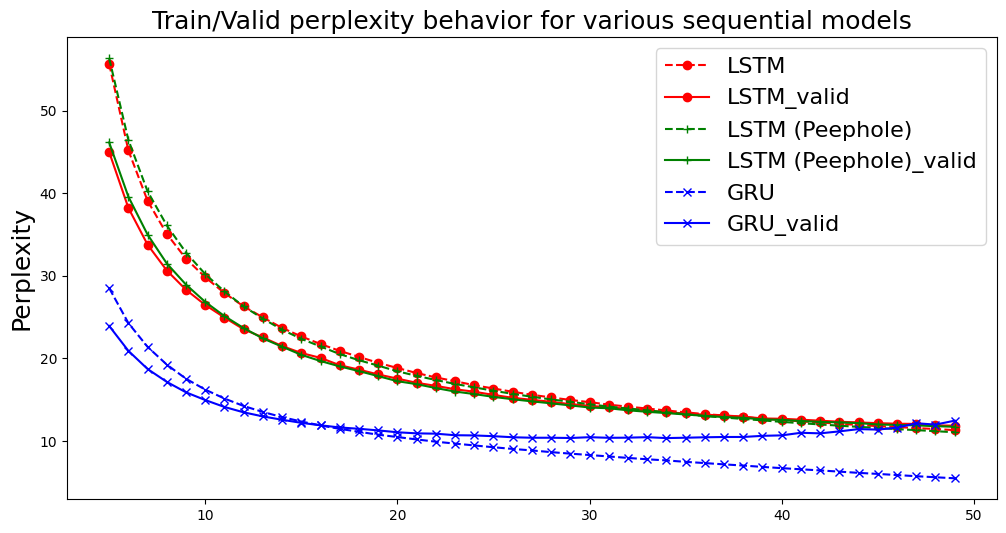

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plots without the Word2vec related results
plt.figure(figsize=(12, 6)) 
k = 5

for model_name, history, marker, color in zip(
    ['LSTM', 'LSTM (Peephole)', 'GRU'], 
    [lstm_history, lstm_peephole_history, gru_history],
    ['o', '+', 'x'],
    ['red', 'green', 'blue']
):
    
    train_perplexity = history.history["perplexity"][k:]
    val_perplexity = history.history["val_perplexity"][k:]
    
    # Plot the training perplexities
    plt.plot(np.arange(k,len(train_perplexity)+k), 
               train_perplexity, marker=marker, markersize=6, linestyle='--' , color=color,
               label = model_name)
    
    plt.plot(np.arange(k, len(val_perplexity)+k), 
           val_perplexity, marker=marker, markersize=6, color=color,
           label = model_name+'_valid')

plt.legend(loc=1,fontsize=16)
plt.title('Train/Valid perplexity behavior for various sequential models',fontsize=18)
plt.ylabel('Perplexity',fontsize=18)

## LSTM with Beam-Search

Here we alter the previously defined prediction related TensorFlow operations to employ beam-search. 

Beam search is a way of predicting several time steps ahead. Concretely instead of predicting the best prediction we have at a given time step, we get predictions for several time steps and get the sequence of highest joint probability.

In [35]:
def beam_one_step(model, input_, states): 
    """ Perform the model update and output for one step"""
    out = model.predict([input_, *states], verbose=0)
    output, new_states = out[0], out[1:]
    return output, new_states


def beam_search(model, input_, states, beam_depth=5, beam_width=3):
    """ Defines an outer wrapper for the computational function of beam search """
    
    vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
    index_word = dict(zip(range(len(vocabulary)), vocabulary))

    def recursive_fn(input_, states, sequence, log_prob, i):
        """ This function performs actual recursive computation of the long string"""
        
        if i == beam_depth:
            """ Base case: Terminate the beam search """
            results.append((list(sequence), states, np.exp(log_prob)))            
            return sequence, log_prob, states
        else:
            """ Recursive case: Keep computing the output using the previous outputs"""
            output, new_states = beam_one_step(model, input_, states)
            
            # Get the top beam_widht candidates for the given depth
            top_probs, top_ids = tf.nn.top_k(output, k=beam_width)
            top_probs, top_ids = top_probs.numpy().ravel(), top_ids.numpy().ravel()
            
            # For each candidate compute the next prediction
            for p, wid in zip(top_probs, top_ids):                
                new_log_prob = log_prob + np.log(p)
                
                # we are going to penalize joint probability whenever the same symbol is repeating
                if len(sequence)>0 and wid == sequence[-1]:
                    new_log_prob = new_log_prob + np.log(1e-1)
                    
                sequence.append(wid)                
                _ = recursive_fn(np.array([[index_word[wid]]]), new_states, sequence, new_log_prob, i+1)                                         
                sequence.pop()
        
    
    results = []
    sequence = []
    log_prob = 0.0
    recursive_fn(input_, states, sequence, log_prob, 0)    

    results = sorted(results, key=lambda x: x[2], reverse=True)

    return results

In [ ]:
text = ["When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren ground"]

vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
index_word = dict(zip(range(len(vocabulary)), vocabulary))


seq = [text[0][i:i+2] for i in range(0, len(text[0]), 2)]

# build up model state using the given string
print(f"Making {len(seq)} predictions from input")


# Reset the state of the model initially
lm_model.reset_states()

# Definin the initial state as all zeros
state_c = np.zeros(shape=(1,512))
state_h = np.zeros(shape=(1,512))
state_c_1 = np.zeros(shape=(1,256))
state_h_1 = np.zeros(shape=(1,256))

states = [state_c, state_h, state_c_1, state_h_1]

# Recursively update the model by assining new state to state
for c in seq:    
    out, state_c, state_h, state_c_1, state_h_1 = infer_model.predict(
        [np.array([[c]]), state_c, state_h, state_c_1, state_h_1], verbose=0
)

# Get final prediction after feeding the input string
wid = int(np.argmax(out[0],axis=-1).ravel())
word = index_word[wid]
text.append(word)

# Define first input to generate text recursively from
x = np.array([[word]])

# Predict for 100 time steps
for i in range(50):    
    print('.', end='')
    
    # Get the results from beam search
    result = beam_search(infer_model, x, states, 5, 5)
    
    # Get one of the top 10 results based on their likelihood
    n_probs = np.array([p for _,_,p in result[:10]])
    p_j = np.random.choice(list(range(n_probs.size)), p=n_probs/n_probs.sum())                    
    best_beam_ids, states, _ = result[p_j]
    x = np.array([[index_word[best_beam_ids[-1]]]])
            
    text.extend([index_word[w] for w in best_beam_ids])    

print('\n')
print('='*60)
print("Final text: ")
print(''.join(text))

Making 58 predictions from input
..................................................